In [1]:
import pandas as pd
import numpy as np
import requests
import os
import tweepy
import json
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Gathering

Sources:

* CSV
* programmatic download from website
* Twitter API's JSON data

Resolved a [tweepy installation issue](https://stackoverflow.com/questions/38739694/install-python-package-package-missing-in-current-win-64-channels).

In [12]:
archive_df = pd.read_csv('twitter-archive-enhanced.csv')
archive_df.sample(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1669,682429480204398592,NaN,NaN,2015-12-31 05:14:01 +0000,"<a href=""http://twitter.com/download/iphone"" r...","I know we joke around on here, but this is get...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/682429480...,8,10,None,None,None,None,None
1996,672591762242805761,NaN,NaN,2015-12-04 01:42:26 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Taz. He boxes leaves. 10/10 https://t....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/672591762...,10,10,Taz,None,None,None,None
1800,676975532580409345,NaN,NaN,2015-12-16 04:01:59 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cooper. He doesn't know how cheese wor...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/676975532...,11,10,Cooper,None,None,None,None


In [13]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)

folder = 'image-predictions'
if not os.path.exists(folder):
    os.makedirs(folder)
    
with open(os.path.join(folder, url.split('/')[-1]), mode='wb') as file:
    file.write(response.content)
    
os.listdir(folder)

img_predictions_df = pd.read_csv(folder + '/image-predictions.tsv', sep='\t')
img_predictions_df.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
2001,876484053909872640,https://pbs.twimg.com/media/DCnll_dUQAAkBdG.jpg,1,golden_retriever,0.874566,True,Irish_terrier,0.037354,True,chow,0.016724,True
1081,718246886998687744,https://pbs.twimg.com/media/Cfe5tLWXEAIaoFO.jpg,1,Chihuahua,0.354488,True,carton,0.159672,False,Siberian_husky,0.057498,True
143,668620235289837568,https://pbs.twimg.com/media/CUdqjvAWUAANfoU.jpg,1,crash_helmet,0.757942,False,toaster,0.037497,False,mouse,0.027271,False
1120,726828223124897792,https://pbs.twimg.com/media/ChY2aHyWMAAbNQE.jpg,1,miniature_pinscher,0.255327,True,Border_terrier,0.181279,True,Labrador_retriever,0.125185,True
820,692919143163629568,https://pbs.twimg.com/media/CZ2-SRiWcAIjuM5.jpg,1,Saint_Bernard,0.612635,True,English_springer,0.269744,True,boxer,0.048666,True


**Hide these keys before publishing or sharing notebook.**

In [8]:
key = "XXXX"
key_secret = "XXXX"
token = "XXXX"
token_secret = "XXXX"

auth = tweepy.OAuthHandler(key, key_secret)
auth.set_access_token(token, token_secret)

api = tweepy.API(auth)

I could skip over grabbing all the JSON data for each tweet and grab the `retweet_count` and `favorite_count` directly from the [status response](https://stackoverflow.com/questions/27900451/convert-tweepy-status-object-into-json#27901076). However, this project requires that I demonstrate how to [write JSON data to a file](http://stackabuse.com/reading-and-writing-json-to-a-file-in-python/), then load it into a pandas dataframe.

In [9]:
tweet_ids = list(archive_df.tweet_id)

tweet_data = {}
for tweet in tweet_ids:
    try:
        tweet_status = api.get_status(tweet, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)
        tweet_data[str(tweet)] = tweet_status._json
        #print(tweet_ids.index(tweet) + 1, "/", "2354")
    except:
        print("Error for: " + str(tweet))
        #print(tweet_ids.index(tweet) + 1, "/", "2354")

Error for: 888202515573088257
Error for: 869988702071779329
Error for: 861769973181624320
Error for: 802247111496568832
Error for: 775096608509886464
Rate limit reached. Sleeping for: 636
Rate limit reached. Sleeping for: 635


In [10]:
with open('tweet_json.txt', 'w') as file:
    json.dump(tweet_data, file)

In [14]:
with open('tweet_json.txt') as file:
    data = json.load(file)
    
df_list = []

for tweet_id in data.keys():
    retweets = data[tweet_id]['retweet_count']
    favorites = data[tweet_id]['favorite_count']# + data[tweet_id]['favourites_count']
    df_list.append({'tweet_id': tweet_id,
                        'retweets': retweets,
                        'favorites': favorites})
    
tweets_df = pd.DataFrame(df_list, columns = ['tweet_id', 'retweets', 'favorites'])
tweets_df.sample(5)

,tweet_id,retweets,favorites
1608,685315239903100929,1224,3649
1170,720043174954147842,2232,5304
639,793195938047070209,6478,16983
1022,746056683365994496,927,3876
1207,715342466308784130,764,3274


Why did `favourites_count` fail? Is `favourites_count` in every tweet's data?

# Assessment

Three dataframes:
 * `tweets_df` which has retweet and favorite counts
 * `img_predictions_df` has the results of a neural network trying to identify dog breed in a tweet's picture
 * `archve_df` has the tweet's text, rating, and dog category

In [112]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2351 entries, 0 to 2350
Data columns (total 3 columns):
tweet_id     2351 non-null object
retweets     2351 non-null int64
favorites    2351 non-null int64
dtypes: int64(2), object(1)
memory usage: 55.2+ KB


In [113]:
img_predictions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [114]:
archive_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [115]:
img_predictions_df.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [116]:
archive_df.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [117]:
tweets_df.describe()

,retweets,favorites
count,2351.000000,2351.000000
mean,3128.737984,8108.334326
std,5234.399386,11983.819346
min,0.000000,0.000000
25%,617.000000,1417.500000
50%,1452.000000,3590.000000
75%,3620.000000,10111.000000
max,78955.000000,132094.000000


In [118]:
all_columns = pd.Series(list(tweets_df) + list(archive_df) + list(img_predictions_df))
all_columns[all_columns.duplicated()]

3     tweet_id
20    tweet_id
dtype: object

In [119]:
archive_df.name.value_counts().head(5)

None       745
a           55
Charlie     12
Oliver      11
Lucy        11
Name: name, dtype: int64

In [120]:
archive_df[archive_df.tweet_id.duplicated()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [121]:
archive_df[archive_df.rating_numerator == 1776]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
979,749981277374128128,NaN,NaN,2016-07-04 15:00:45 +0000,"<a href=""https://about.twitter.com/products/tw...",This is Atticus. He's quite simply America af....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/749981277...,1776,10,Atticus,None,None,None,None


## Issues

Completeness

* missing retweet and favorite data for 5 tweets (`tweets_df`)
* missing img predictions for some tweets (`img_predictions_df`)

The missing retweet and favorite data is unrecoverable. There is no status data available from the Twitter API and not all tweets have an image. I did not confirm that all tweets with an image stored the image.

Tidiness

* `retweets` and `favorites` in their own table (`tweets_df`)
* dog stages in multiple columns (`archive_df`)
* three separate tables

Validity

_archive_
* `tweet_id` is int
* `timestamp` is str
* `in_reply_to_status_id` is float
* `in_reply_to_user_id` is float
* `retweeted_status_id` is float
* `retweeted_status_user_id` is float
* `retweeted_status_timestamp` is str
* dog stages are str
* `text` is cut off with ellipses
* incorrect dog names (a, an, the, just, one, very, quite, not, actually, mad, space, infuriating, all, officially, 0, old, life, unacceptable, my, incredibly, by, his, such)

_img predictions_
* `tweet_id` is int in `img_predictions_df` 

_tweets_
* retweets and favorites are float


I am not retrieving the rest of the tweet text at this time.

Accuracy

* None

Consistency

* meaningful but inconsistent numerators and denominators (`archive_df`)


# Cleaning

### Tidiness

**Define:** `retweets` and `favorites` in their own table (`tweets_df`)

**Code:** Convert `tweet_id` in `archive_df` to string. Inner join `tweets_df`, `archive_df`, and `img_predictions` on tweet_id.

In [15]:
archive_clean = archive_df.copy()
tweets_clean = tweets_df.copy()
img_pred_clean = img_predictions_df.copy()

In [16]:
img_pred_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [17]:
archive_clean.tweet_id = archive_clean.tweet_id.astype(str)
img_pred_clean.tweet_id = img_pred_clean.tweet_id.astype(str)
archive_clean = pd.merge(archive_clean, tweets_clean,
                        how = 'inner', on = 'tweet_id')
archive_clean = pd.merge(archive_clean, img_pred_clean,
                        how = 'inner', on = 'tweet_id')

**Test**

In [18]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2072 entries, 0 to 2071
Data columns (total 30 columns):
tweet_id                      2072 non-null object
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     2072 non-null object
source                        2072 non-null object
text                          2072 non-null object
retweeted_status_id           78 non-null float64
retweeted_status_user_id      78 non-null float64
retweeted_status_timestamp    78 non-null object
expanded_urls                 2072 non-null object
rating_numerator              2072 non-null int64
rating_denominator            2072 non-null int64
name                          2072 non-null object
doggo                         2072 non-null object
floofer                       2072 non-null object
pupper                        2072 non-null object
puppo                         2072 non-null object
retweets                      2072

In [19]:
archive_clean.sample(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
921,732005617171337216,NaN,NaN,2016-05-16 00:31:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Larry. He has no self control. Tongue ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/732005617...,...,1,English_setter,0.677408,True,Border_collie,0.052724,True,cocker_spaniel,0.048572,True
1188,698907974262222848,NaN,NaN,2016-02-14 16:33:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This dog is never sure if he's doing the right...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/698907974...,...,3,German_short-haired_pointer,0.983131,True,bluetick,0.005558,True,curly-coated_retriever,0.003322,True
1011,715009755312439296,NaN,NaN,2016-03-30 02:56:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Siba. She's remarkably mobile. Very sl...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/715009755...,...,1,dingo,0.310903,False,Chihuahua,0.142288,True,Cardigan,0.103945,True


In [8]:
archive_clean[archive_clean.retweets.isnull()]
#sum(archive_clean.retweets.isnull())

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,retweets,favorites
19,888202515573088257,NaN,NaN,2017-07-21 01:02:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Canela. She attempted s...,8.874740e+17,4.196984e+09,2017-07-19 00:47:34 +0000,https://twitter.com/dog_rates/status/887473957...,13,10,Canela,None,None,None,None,NaN,NaN
118,869988702071779329,NaN,NaN,2017-05-31 18:47:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: We only rate dogs. This is quit...,8.591970e+17,4.196984e+09,2017-05-02 00:04:57 +0000,https://twitter.com/dog_rates/status/859196978...,12,10,quite,None,None,None,None,NaN,NaN
155,861769973181624320,NaN,NaN,2017-05-09 02:29:07 +0000,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: ""Good afternoon class today we'...",8.066291e+17,4.196984e+09,2016-12-07 22:38:52 +0000,https://twitter.com/dog_rates/status/806629075...,13,10,None,None,None,None,None,NaN,NaN
566,802247111496568832,NaN,NaN,2016-11-25 20:26:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Everybody drop what you're doin...,7.790561e+17,4.196984e+09,2016-09-22 20:33:42 +0000,https://twitter.com/dog_rates/status/779056095...,13,10,None,None,None,None,None,NaN,NaN
784,775096608509886464,NaN,NaN,2016-09-11 22:20:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: After so many requests, this is...",7.403732e+17,4.196984e+09,2016-06-08 02:41:38 +0000,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None,NaN,NaN


**Define:** dog categories hide category variable (`archive_df`)

**Code:** Melt dog stage columns into single column.

In [20]:
archive_clean = pd.melt(archive_clean,
                        id_vars=['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id',
                                 'timestamp', 'source', 'text', 'retweeted_status_id',
                                 'retweeted_status_user_id', 'retweeted_status_timestamp',
                                 'expanded_urls', 'rating_numerator', 'rating_denominator',
                                 'name', 'retweets', 'favorites', 'jpg_url', 'img_num', 'p1',
                                 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf',
                                 'p3_dog'],
                        value_name='dog_stage')
archive_clean = archive_clean.drop('variable', axis=1)

**Test**

In [21]:
archive_clean.sample(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_stage
845,745057283344719872,NaN,NaN,2016-06-21 00:54:33 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Oliver. He's downright gorgeous as hel...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/745057283...,...,Shetland_sheepdog,0.963985,True,collie,0.026206,True,Border_collie,0.004544,True,None
3300,695064344191721472,NaN,NaN,2016-02-04 02:00:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This may be the greatest video I've ever been ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/695064344...,...,seat_belt,0.522211,False,sunglasses,0.077552,False,ice_lolly,0.051774,False,None
1874,669603084620980224,NaN,NaN,2015-11-25 19:46:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Very human-like. Cute overbite smile *finger t...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/669603084...,...,Maltese_dog,0.659619,True,Tibetan_terrier,0.193539,True,Shih-Tzu,0.039327,True,None


In [22]:
len(archive_clean[archive_clean.dog_stage != 'None'])

334

In [23]:
archive_clean.dog_stage.value_counts()

None       7954
pupper      222
doggo        80
puppo        24
floofer       8
Name: dog_stage, dtype: int64

In [24]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8288 entries, 0 to 8287
Data columns (total 27 columns):
tweet_id                      8288 non-null object
in_reply_to_status_id         92 non-null float64
in_reply_to_user_id           92 non-null float64
timestamp                     8288 non-null object
source                        8288 non-null object
text                          8288 non-null object
retweeted_status_id           312 non-null float64
retweeted_status_user_id      312 non-null float64
retweeted_status_timestamp    312 non-null object
expanded_urls                 8288 non-null object
rating_numerator              8288 non-null int64
rating_denominator            8288 non-null int64
name                          8288 non-null object
retweets                      8288 non-null int64
favorites                     8288 non-null int64
jpg_url                       8288 non-null object
img_num                       8288 non-null int64
p1                            8288

In [25]:
# Keep one of 3 duplicates with 'None'
dup_df1 = archive_clean.drop_duplicates(subset=['tweet_id', 'dog_stage']) 
dup_df1 = archive_clean.drop_duplicates()

# Keep rows with dog stage
dup_pos = archive_clean.duplicated(subset='tweet_id', keep = False)
dup_df2 = archive_clean[dup_pos]
dup_df2 = dup_df2[dup_df2.dog_stage != 'None']

# Combine
dup_df1 = dup_df1.drop_duplicates(subset = 'tweet_id', keep = False)
dup_df_merged = dup_df1.append(dup_df2)

In [26]:
dup_df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2085 entries, 0 to 7104
Data columns (total 27 columns):
tweet_id                      2085 non-null object
in_reply_to_status_id         24 non-null float64
in_reply_to_user_id           24 non-null float64
timestamp                     2085 non-null object
source                        2085 non-null object
text                          2085 non-null object
retweeted_status_id           80 non-null float64
retweeted_status_user_id      80 non-null float64
retweeted_status_timestamp    80 non-null object
expanded_urls                 2085 non-null object
rating_numerator              2085 non-null int64
rating_denominator            2085 non-null int64
name                          2085 non-null object
retweets                      2085 non-null int64
favorites                     2085 non-null int64
jpg_url                       2085 non-null object
img_num                       2085 non-null int64
p1                            2085 no

In [27]:
remaining_dup_df = dup_df_merged[dup_df_merged.duplicated(subset='tweet_id', keep=False)]
remaining_dup_df[remaining_dup_df.tweet_id == '817777686764523521']

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_stage
365,817777686764523521,NaN,NaN,2017-01-07 16:59:28 +0000,"<a href=""http://twitter.com/download/iphone"" r...","This is Dido. She's playing the lead role in ""...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/817777686...,...,curly-coated_retriever,0.733256,True,flat-coated_retriever,0.214145,True,Irish_water_spaniel,0.029769,True,doggo
4509,817777686764523521,NaN,NaN,2017-01-07 16:59:28 +0000,"<a href=""http://twitter.com/download/iphone"" r...","This is Dido. She's playing the lead role in ""...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/817777686...,...,curly-coated_retriever,0.733256,True,flat-coated_retriever,0.214145,True,Irish_water_spaniel,0.029769,True,pupper


**Define:** Duplicate tweets from multiple dog stages.

**Code:** Multiple stages appear in 14 tweets. Change `dog_stage` to _multiple_, drop duplicates. Remove drop duplicates from `archive_clean` based on `tweet_id`, then append `multiple` rows.

In [29]:
remaining_dup_df.dog_stage = 'multiple'
dup_drops = remaining_dup_df.drop_duplicates()
dup_drops[dup_drops.tweet_id == '817777686764523521']

C:\Users\Nathan\Anaconda\envs\py3\lib\site-packages\pandas\core\generic.py:2773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_stage
365,817777686764523521,NaN,NaN,2017-01-07 16:59:28 +0000,"<a href=""http://twitter.com/download/iphone"" r...","This is Dido. She's playing the lead role in ""...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/817777686...,...,curly-coated_retriever,0.733256,True,flat-coated_retriever,0.214145,True,Irish_water_spaniel,0.029769,True,multiple


In [30]:
duped_ids = set(remaining_dup_df.tweet_id)
for idx in dup_df_merged.tweet_id:
    if idx in duped_ids:
        dup_df_merged.dog_stage[dup_df_merged.tweet_id == idx] = 'multiple'
archive_clean = dup_df_merged.drop_duplicates()

C:\Users\Nathan\Anaconda\envs\py3\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


**Test**

In [31]:
archive_clean.dog_stage.value_counts()

None        1751
pupper       211
doggo         67
puppo         23
multiple      13
floofer        7
Name: dog_stage, dtype: int64

In [32]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2072 entries, 0 to 7104
Data columns (total 27 columns):
tweet_id                      2072 non-null object
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     2072 non-null object
source                        2072 non-null object
text                          2072 non-null object
retweeted_status_id           78 non-null float64
retweeted_status_user_id      78 non-null float64
retweeted_status_timestamp    78 non-null object
expanded_urls                 2072 non-null object
rating_numerator              2072 non-null int64
rating_denominator            2072 non-null int64
name                          2072 non-null object
retweets                      2072 non-null int64
favorites                     2072 non-null int64
jpg_url                       2072 non-null object
img_num                       2072 non-null int64
p1                            2072 no

### Validity

**Define:** Convert float variables (`in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id`) to object.

**Code:** Convert tweet_id to string

In [33]:
archive_clean.in_reply_to_status_id = archive_clean.in_reply_to_status_id.astype(str)
archive_clean.in_reply_to_user_id = archive_clean.in_reply_to_user_id.astype(str)
archive_clean.retweeted_status_id = archive_clean.retweeted_status_id.astype(str)
archive_clean.retweeted_status_user_id = archive_clean.retweeted_status_user_id.astype(str)

C:\Users\Nathan\Anaconda\envs\py3\lib\site-packages\pandas\core\generic.py:2773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


**Test**

In [34]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2072 entries, 0 to 7104
Data columns (total 27 columns):
tweet_id                      2072 non-null object
in_reply_to_status_id         2072 non-null object
in_reply_to_user_id           2072 non-null object
timestamp                     2072 non-null object
source                        2072 non-null object
text                          2072 non-null object
retweeted_status_id           2072 non-null object
retweeted_status_user_id      2072 non-null object
retweeted_status_timestamp    78 non-null object
expanded_urls                 2072 non-null object
rating_numerator              2072 non-null int64
rating_denominator            2072 non-null int64
name                          2072 non-null object
retweets                      2072 non-null int64
favorites                     2072 non-null int64
jpg_url                       2072 non-null object
img_num                       2072 non-null int64
p1                            207

**Define:** Convert object variables (`timestamp` and `retweeted_status_timestamp`) to datetime.

**Code:** Convert timestamp to datetime object.

In [35]:
archive_clean.timestamp = pd.to_datetime(archive_clean.timestamp)
archive_clean.retweeted_status_timestamp = pd.to_datetime(archive_clean.retweeted_status_timestamp)

C:\Users\Nathan\Anaconda\envs\py3\lib\site-packages\pandas\core\generic.py:2773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


**Test**

In [36]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2072 entries, 0 to 7104
Data columns (total 27 columns):
tweet_id                      2072 non-null object
in_reply_to_status_id         2072 non-null object
in_reply_to_user_id           2072 non-null object
timestamp                     2072 non-null datetime64[ns]
source                        2072 non-null object
text                          2072 non-null object
retweeted_status_id           2072 non-null object
retweeted_status_user_id      2072 non-null object
retweeted_status_timestamp    78 non-null datetime64[ns]
expanded_urls                 2072 non-null object
rating_numerator              2072 non-null int64
rating_denominator            2072 non-null int64
name                          2072 non-null object
retweets                      2072 non-null int64
favorites                     2072 non-null int64
jpg_url                       2072 non-null object
img_num                       2072 non-null int64
p1               

In [37]:
archive_clean.sample(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_stage
1824,670668383499735048,nan,nan,2015-11-28 18:19:37,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a magical dog. Only appe...,nan,nan,NaT,https://twitter.com/dog_rates/status/670668383...,...,banana,0.107317,False,orange,0.099662,False,bagel,0.089033,False,None


**Define:** dog categories are str (`archive_df`)

**Code:** convert `dog_stage` to categorical type

In [38]:
archive_clean.dog_stage = archive_clean.dog_stage.astype('category')

C:\Users\Nathan\Anaconda\envs\py3\lib\site-packages\pandas\core\generic.py:2773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


**Test**

In [39]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2072 entries, 0 to 7104
Data columns (total 27 columns):
tweet_id                      2072 non-null object
in_reply_to_status_id         2072 non-null object
in_reply_to_user_id           2072 non-null object
timestamp                     2072 non-null datetime64[ns]
source                        2072 non-null object
text                          2072 non-null object
retweeted_status_id           2072 non-null object
retweeted_status_user_id      2072 non-null object
retweeted_status_timestamp    78 non-null datetime64[ns]
expanded_urls                 2072 non-null object
rating_numerator              2072 non-null int64
rating_denominator            2072 non-null int64
name                          2072 non-null object
retweets                      2072 non-null int64
favorites                     2072 non-null int64
jpg_url                       2072 non-null object
img_num                       2072 non-null int64
p1               

**Define:** retweets and favorites are float

**Code:** Fill NaNs with median values.

In [40]:
median_retweet = np.median(archive_clean.retweets.dropna())
median_favorite = np.median(archive_clean.favorites.dropna())
print(median_retweet, median_favorite)

1396.0 3845.0


In [41]:
archive_clean.retweets = archive_clean.retweets.fillna(median_retweet).astype('int64')
archive_clean.favorites = archive_clean.favorites.fillna(median_favorite).astype('int64')

C:\Users\Nathan\Anaconda\envs\py3\lib\site-packages\pandas\core\generic.py:2773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


**Test**

In [42]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2072 entries, 0 to 7104
Data columns (total 27 columns):
tweet_id                      2072 non-null object
in_reply_to_status_id         2072 non-null object
in_reply_to_user_id           2072 non-null object
timestamp                     2072 non-null datetime64[ns]
source                        2072 non-null object
text                          2072 non-null object
retweeted_status_id           2072 non-null object
retweeted_status_user_id      2072 non-null object
retweeted_status_timestamp    78 non-null datetime64[ns]
expanded_urls                 2072 non-null object
rating_numerator              2072 non-null int64
rating_denominator            2072 non-null int64
name                          2072 non-null object
retweets                      2072 non-null int64
favorites                     2072 non-null int64
jpg_url                       2072 non-null object
img_num                       2072 non-null int64
p1               

**Define:** names incorrectly identified from available text

**Code:** replace words with names where available

In [43]:
archive_clean.text[archive_clean.name =='a']
archive_clean.text[archive_clean.name =='an']
archive_clean.text[archive_clean.name =='my']
archive_clean.text[archive_clean.name =='his']

813    That is Quizno. This is his beach. He does not...
Name: text, dtype: object

In [44]:
archive_clean.name[2204] = 'Berta'
archive_clean.name[2034] = 'Jacob'
archive_clean.name[2066] = 'Rufus'
archive_clean.name[2116] = 'Spork'
archive_clean.name[2125] = 'Cherokee'
archive_clean.name[2161] = 'Alfredo'
archive_clean.name[2218] = 'Chuk'
archive_clean.name[2235] = 'Alfonso'
archive_clean.name[2249] = 'Cheryl'
archive_clean.name[2255] = 'Jessiga'
archive_clean.name[2264] = 'Klint'
archive_clean.name[2273] = 'Kohl'
archive_clean.name[2304] = 'Pepe'
archive_clean.name[2311] = 'Octaviath'
archive_clean.name[archive_clean.name == 'my'] = 'Zoey'
archive_clean.name[archive_clean.name == 'his'] = 'Quizno'

C:\Users\Nathan\Anaconda\envs\py3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\Nathan\Anaconda\envs\py3\lib\site-packages\pandas\core\series.py:749: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.loc[key] = value
C:\Users\Nathan\Anaconda\envs\py3\lib\site-packages\IPython\core\interactiveshell.py:2881: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Use

**Test**

In [45]:
archive_clean.loc[archive_clean.name == 'Berta']
archive_clean.loc[archive_clean.name == 'Jacob']
archive_clean.loc[archive_clean.name == 'Rufus']
archive_clean.loc[archive_clean.name == 'Spork']
archive_clean.loc[archive_clean.name == 'Cherokee']
archive_clean.loc[archive_clean.name == 'Alfredo']
archive_clean.loc[archive_clean.name == 'Chuk']
archive_clean.loc[archive_clean.name == 'Alfonso']
archive_clean.loc[archive_clean.name == 'Cheryl']
archive_clean.loc[archive_clean.name == 'Jessiga']
archive_clean.loc[archive_clean.name == 'Klint']
archive_clean.loc[archive_clean.name == 'Kohl']
archive_clean.loc[archive_clean.name == 'Pepe']
archive_clean.loc[archive_clean.name == 'Octaviath']
archive_clean.loc[archive_clean.name == 'Zoey']
archive_clean.loc[archive_clean.name == 'Quizno']

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_stage
813,748692773788876800,nan,nan,2016-07-01 01:40:41,"<a href=""http://twitter.com/download/iphone"" r...",That is Quizno. This is his beach. He does not...,nan,nan,NaT,https://twitter.com/dog_rates/status/748692773...,...,ox,0.337871,False,plow,0.269287,False,oxcart,0.245653,False,doggo


I noticed that the text for each tweet is incomplete. I am not correcting this at this time.

**Define:** incorrect dog names (a, an, the, just, one, very, quite, not, actually, mad, space, infuriating, all, officially, 0, old, life, unacceptable, my, incredibly, by, his, such) (`archive_df`)

**Code:** Replace "a, an, the, just, one, very, quite, not, actually, mad, space, infuriating, all, officially, 0, old, life, unacceptable, my, incredibly, by, his, such" with "None".

In [46]:
non_names = ['a', 'an', 'the', 'just', 'one', 'very', 'quite', 'not', 'actually', 
             'mad', 'space', 'infuriating', 'all', 'officially', '0', 'old', 'life',
             'unacceptable', 'my', 'incredibly', 'by', 'his', 'such']

for name in archive_clean.name:
    if name in non_names:
        archive_clean.name[archive_clean.name == name] = 'None'

C:\Users\Nathan\Anaconda\envs\py3\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Nathan\Anaconda\envs\py3\lib\site-packages\pandas\core\generic.py:4702: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


**Test**

In [47]:
archive_clean.name.value_counts()[:10]

None       669
Charlie     11
Penny       10
Oliver      10
Cooper      10
Lucy        10
Tucker      10
Lola         8
Bo           8
Winston      8
Name: name, dtype: int64

**Define:** meaningful but inconsistent numerators and denominators (`archive_df`)

In [48]:
archive_clean.rating_denominator.value_counts()

10     2054
50        3
11        2
80        2
7         1
170       1
150       1
130       1
120       1
110       1
90        1
70        1
40        1
20        1
2         1
Name: rating_denominator, dtype: int64

While these numerators and denominators have strange values, the reason for that is for humor. These are intentional, not errors. I will leave them as they are.

# Store

In [50]:
archive_clean.to_csv('twitter_archive_master.csv', encoding='utf-8', index=False)

# Analysis

What does the relationship between retweets and favorites look like? 5 tweets had missing values for retweets and favorites, so I filled those in with median values for their respective variables.

C:\Users\Nathan\Anaconda\envs\py3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


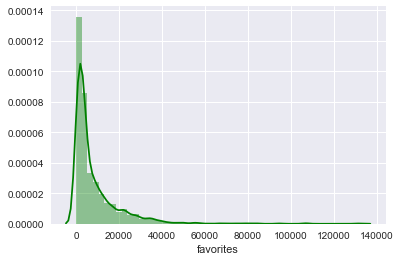

In [51]:
sns.distplot(archive_clean.favorites, color = 'green', label = 'Favorites')

sns.plt.show()

C:\Users\Nathan\Anaconda\envs\py3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


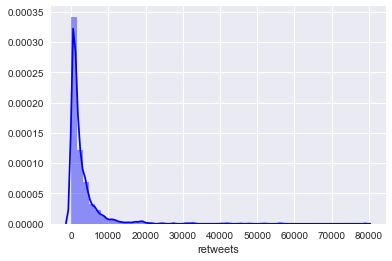

In [52]:
sns.distplot(archive_clean.retweets, color = 'blue', label = 'Retweets')
sns.plt.show()

Trying to log transform the favorites and retweets variables so I can get a normal distribution. I'm adding some artificial jitter by setting the zero values to ones.

In [53]:
favorities_lognormed = archive_clean.favorites[archive_clean.favorites <= 0] = 1
retweets_lognormed = archive_clean.retweets[archive_clean.retweets <= 0] = 1

C:\Users\Nathan\Anaconda\envs\py3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\Nathan\Anaconda\envs\py3\lib\site-packages\pandas\core\generic.py:4702: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
C:\Users\Nathan\Anaconda\envs\py3\lib\site-packages\IPython\core\interactiveshell.py:2881: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user

C:\Users\Nathan\Anaconda\envs\py3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


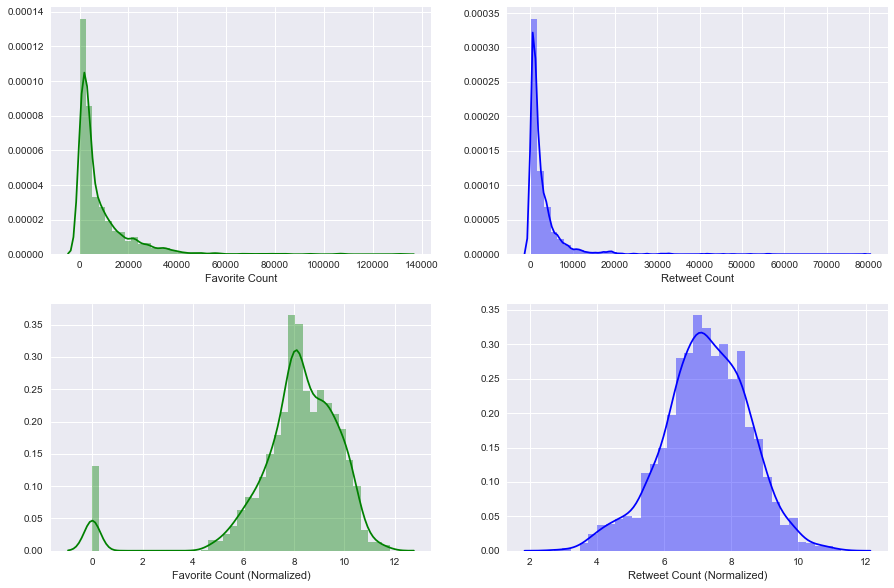

In [55]:
f, axes = plt.subplots(2,2,figsize=(15,10),sharex=False)

sns.distplot(archive_clean.favorites, color = 'green', ax=axes[0,0], axlabel='Favorite Count')
sns.distplot(archive_clean.retweets, color = 'blue', ax=axes[0,1], axlabel='Retweet Count')
sns.distplot(archive_clean.favorites.apply(np.log), color = 'green', ax=axes[1,0], axlabel='Favorite Count (Normalized)')
sns.distplot(archive_clean.retweets.apply(np.log), color = 'blue', ax=axes[1,1], axlabel='Retweet Count (Normalized)')

sns.plt.show()
f.savefig('distplots.png')

The original distributions for both favorites and retweets have long positive tails. _Extremely popular tweets are extremely rare._ The normalized graphs (the bottom two) again show similar distributions. They are roughly normal except for the spike in values for the normalized favorite count. That may be due to my jitter work and not an actual attribute of the data. Or there are actually a bunch of tweets with one favorite count.

The two variables seem to have similar distributions implying that the _two measurements are representing similar phenomona_. 

In [56]:
archive_clean.retweets.describe()

count     2072.000000
mean      2951.679537
std       5019.433953
min         15.000000
25%        628.000000
50%       1396.000000
75%       3411.500000
max      78955.000000
Name: retweets, dtype: float64

In [57]:
archive_clean.favorites.describe()

count      2072.000000
mean       8577.697394
std       12269.446642
min           1.000000
25%        1664.250000
50%        3845.000000
75%       10894.750000
max      132094.000000
Name: favorites, dtype: float64

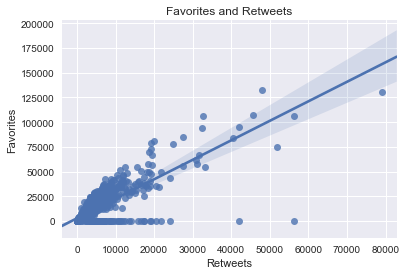

In [58]:
g = sns.regplot(x=archive_clean.retweets, y=archive_clean.favorites)
plt.title("Favorites and Retweets")
plt.xlabel('Retweets')
plt.ylabel('Favorites')
sns.plt.show()
fig = g.get_figure()
fig.savefig('scatterplot.png')

In [59]:
archive_clean.corr()

,rating_numerator,rating_denominator,retweets,favorites,img_num,p1_conf,p1_dog,p2_conf,p2_dog,p3_conf,p3_dog
rating_numerator,1.000000,0.198243,0.017736,0.017015,-0.000413,-0.009139,-0.028503,-0.020319,-0.033727,-0.003883,-0.028490
rating_denominator,0.198243,1.000000,-0.022027,-0.026123,-0.004019,-0.004315,0.001000,-0.034415,-0.000498,0.006795,0.005093
retweets,0.017736,-0.022027,1.000000,0.807219,0.103602,0.045426,0.009851,-0.009735,0.023455,-0.032925,0.003055
favorites,0.017015,-0.026123,0.807219,1.000000,0.133704,0.071974,0.052861,-0.020367,0.059634,-0.050244,0.042537
img_num,-0.000413,-0.004019,0.103602,0.133704,1.000000,0.203967,0.027623,-0.160172,0.047263,-0.139320,0.059533
p1_conf,-0.009139,-0.004315,0.045426,0.071974,0.203967,1.000000,0.118523,-0.510987,0.131717,-0.709681,0.109616
p1_dog,-0.028503,0.001000,0.009851,0.052861,0.027623,0.118523,1.000000,0.113482,0.634600,0.048815,0.557212
p2_conf,-0.020319,-0.034415,-0.009735,-0.020367,-0.160172,-0.510987,0.113482,1.000000,0.101829,0.479124,0.067830
p2_dog,-0.033727,-0.000498,0.023455,0.059634,0.047263,0.131717,0.634600,0.101829,1.000000,0.042871,0.551653
p3_conf,-0.003883,0.006795,-0.032925,-0.050244,-0.139320,-0.709681,0.048815,0.479124,0.042871,1.000000,0.042049


There is a strong relationship between retweet and favorite counts (0.72). _As a tweet gains Favorites, one can expect to see Retweets to increase and vice versa_. It looks like it may be a nonlinear relationship.

I am curious about the tweets that have many retweets but zero favorites. I wonder if this may be due to added or subtracted features over time. I noticed that my Twitter doesn't have a "Favorite" button any more. It is now called Like. I have not looked to see whether the Favorite data was removed from the JSON data and replaced with Likes.